In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
237107,1559912500526718977,minha criatividade para elogios acabou a muito...,-0.146058,-1
626596,1160850270621962241,queria ver a live toda mas tenho que ir pra au...,-0.146058,-1
34693,1559755724321955840,assim para certos tuites: 👀📝,0.063415,0
314106,1559962900369915910,"nada me estressa hj, só de ser que mas tarde t...",1.171490,1
814168,1161199545793073152,tenho reunião de trabalho hj e tô com uma cara...,-0.080586,-1
432901,1160380227484360704,é por isso que eu amo muito os dois 💗,0.659091,1
115110,1559858593373065216,bom dia 😎👉👉🇧🇷,1.281040,1
93391,1559844887964557314,laís ia deixa minha mãe famosa no tiktok. fez ...,0.220968,0
319860,1559965223439585280,bravo bebou 🎉,0.739556,1
396444,1160239239348523008,📡📡💯 dg instalações 💯📡📡 👉 serviços com instalaç...,1.793144,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [substring for substring in string_tratada.split() if substring not in stopwords]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join([stemmer.stem(substring) for substring in string_tratada.split()])

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

156          seria
16              de
59     estivéramos
126          nossa
62       estivesse
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: ô delícia 🤤🔥🍆

Tweet Limpo   : ô delícia

Tweet Stemed  : ô delíc


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
161236,1559881656651096064,deus sabe de todas as coisas 🙏☹️,0.417804,1,deu sab tod cois
355010,1559985110681882627,ta sobrando uma quirera ainda graças a ele 🙏,0.417804,1,ta sobr quir aind graç
182271,1559890835008782336,"""na frente dos teus amigos tu se solta e eu go...",1.753140,1,frent amig solt gost diss amo vó
737157,1161011295581298688,e o pneu da moto que furou e eu tive que gasta...,0.006676,0,pneu mot fur gast money compr lanch fd
579575,1160746736283004931,mas vc é! 💜,0.656017,1,vc


# Modelo Soma das Frequencias

Este modelo é extremamente simples.

Vamos transformar o texto numa representação vetorial utilizando o somatório da frequencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

In [11]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [12]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

Chaves: 58366


In [13]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

Chaves: 27524


In [14]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

Chaves: 32001


### Visualização dos Dicionários

In [15]:
dicionarios = pd.DataFrame([
    pd.Series(dicionario_positivo, name="positivo"),
    pd.Series(dicionario_neutro, name="neutro"),
    pd.Series(dicionario_negativo, name="negativo")
]).T

In [16]:
dicionarios.sample(10)

,positivo,neutro,negativo
seguimorees,1.0,NaN,NaN
aaaw,4.0,NaN,1.0
deera,1.0,NaN,NaN
atsuk,1.0,NaN,NaN
valpassosbfr,1.0,NaN,NaN
lucylain,1.0,NaN,NaN
acabej,1.0,NaN,NaN
asmod,2.0,NaN,1.0
faded,NaN,NaN,1.0
percy,14.0,5.0,16.0


## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [17]:
def gerar_feature_vector(
    string, dicionario_positivo, dicionario_neutro, dicionario_negativo
):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([dicionario_positivo.get(word, 0) for word in tokens])
    feature_neutra = sum([dicionario_neutro.get(word, 0) for word in tokens])
    feature_negativa = sum([dicionario_negativo.get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [18]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(tweet, dicionario_positivo, dicionario_neutro, dicionario_negativo)

print("Tweet: {}".format(tweet))
feature_vector

Tweet: infeliz vou ter extrem fri compr photobook yoong


positiva    24929
neutra       6782
negativa    18553
dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [19]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_train["label"] = X_train["label"]

In [20]:
features_train.sample(5)

,positiva,neutra,negativa,label
241851,9118,1253,3077,-1
355266,13070,4441,14373,-1
310229,19985,5737,11521,1
491197,7582,2476,8030,-1
485797,37797,4991,10931,-1


In [21]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

,positiva,neutra,negativa
187920,10150,1653,2564
252528,9483,2554,8435
20816,25141,6592,11033
419429,4386,1294,2101
650746,17749,4986,10228


In [22]:
y_features_train = features_train["label"]
y_features_train.sample(5)

326132   -1
406448   -1
501771    1
270092   -1
576336    0
Name: label, dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [23]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_test["label"] = X_test["label"]

In [24]:
features_test.sample(5)

,positiva,neutra,negativa,label
607280,11354,3594,7216,1
209550,79528,11185,24431,1
35839,8576,2209,4176,1
563451,2521,536,1123,1
806383,32960,8850,18697,-1


In [25]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

,positiva,neutra,negativa
701885,176,53,153
51077,34062,9123,19029
573762,11180,1668,3812
366665,1807,75,37
864514,16146,5297,9498


In [26]:
y_features_test = features_test["label"]
y_features_test.sample(5)

136867    1
424907    1
444329    1
446855    1
301340    1
Name: label, dtype: int64

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
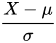

In [27]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler()

In [28]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

,positiva,neutra,negativa
303379,-0.833538,-0.703513,-0.833662
302572,1.806918,1.505163,1.433860
140231,-0.497593,-0.546937,-0.676597
377126,-0.255187,0.284965,-0.268780
23922,-0.369373,-0.306832,-0.144349


In [29]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

,positiva,neutra,negativa
49940,0.354502,0.473630,0.338838
186903,1.506648,0.302541,0.225019
161864,0.373937,0.655523,0.385645
56133,1.191057,-0.057374,-0.028422
64243,0.004339,-0.532263,-0.596793


# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [30]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [31]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [32]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [33]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [34]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [35]:
params = {
    "C": [
        0.47,
        0.53,
        0.59,
        0.61,
        0.67,
        0.71,
        0.73,
        0.79,
        0.83,
        0.89,
        0.97,
        1,
        2,
        3,
        5,
        7,
        9,
        11,
        13,
        17,
        19,
        21,
    ],
    "tol": [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
}

clf = RandomizedSearchCV(log, params, scoring="f1_weighted", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 52.12%


In [36]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [37]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-clf.best_score_)*100))

Score Baseline : 43.03%
Score Modelo   : 52.12%
Diferença      : 9.10%


### Performance no Conjunto de Treino

In [38]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 52.12%


### Curva de Aprendizado

In [39]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

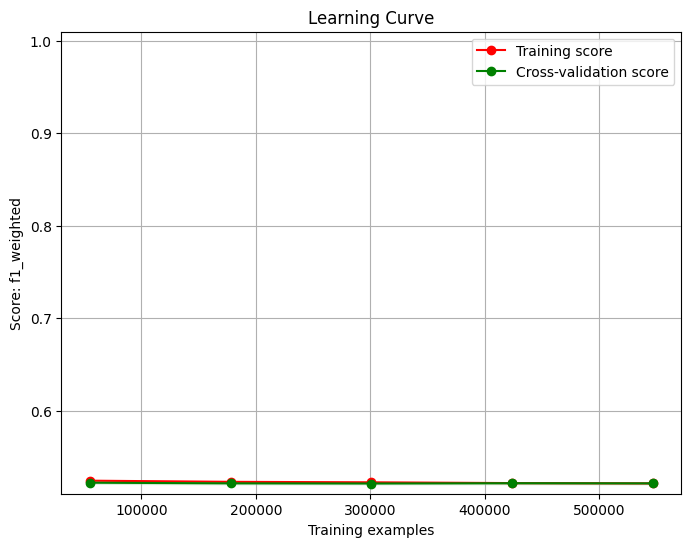

In [40]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Random Forest

Referências:
- [https://en.wikipedia.org/wiki/Random_forest](https://en.wikipedia.org/wiki/Random_forest)
- [https://scikit-learn.org/stable/modules/ensemble.html#forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [41]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

In [42]:
s1 = time()
scores = cross_val_score(
    rf, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
rf_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(rf_score * 100))

Elapsed Time:  54 seconds
F-Score: 58.87%


In [43]:
rf.fit(X_features_train_scaled, y_features_train)

RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search]

In [44]:
# Codigo
# rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
# params = {
#    'n_estimators': [100,200,300],
#    'min_samples_split': [2,3,4,5],
#    'min_samples_leaf': [1,2,3,4],
# }

# clf = RandomizedSearchCV(rf, params, scoring='f1_weighted', random_state=42)
# clf.fit(X_features_train_scaled, y_features_train)

# print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [45]:
# clf.best_params_
print({"n_estimators": 100, "min_samples_split": 2, "min_samples_leaf": 2})

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [46]:
# rf = clf.best_estimator_

#### Comparação com Métrica base

In [47]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(rf_score*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-rf_score)*100))

Score Baseline : 43.03%
Score Modelo   : 58.87%
Diferença      : 15.85%


### Performance no Conjunto de Treino

In [48]:
y_pred = rf.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 89.98%


### Curva de Aprendizado

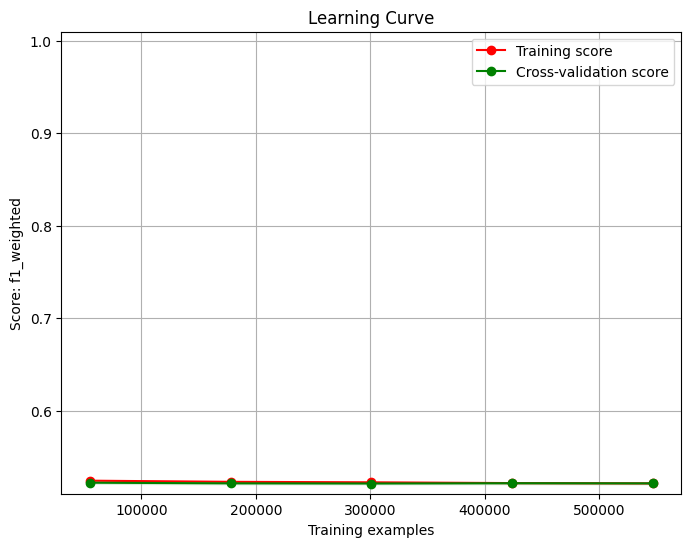

In [49]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [50]:
y_pred = rf.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 58.61%


### Preditos Positivos

In [51]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [52]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['usei c vc até vc tirar 😔', 'mas ele é lindinho demais 😭😭😭',
       'existe. ganharam do meu heat em ... 😔',
       'ninguém me manda bom dia no whatsapp pq sou uma azeda 😤',
       'lavei o belinho 😣', 'que dia corrido, desde cedo na rua 😴',
       'nós odeia a covardia 😠',
       'eu assim 😡😤 chegando na escola com uma raiva da porra com not shy estourando no fone',
       'jep é semana que vem e eu não conheço nem meus colegas de equipe 😪',
       'preciso de uns dias off,mente a mil 😪'], dtype=object)

#### Falso Positivo -> Neutro

In [53]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['é impressionante cara, quando eu encontro os grts eles sempre precisam lembrar de alguma historia 😂',
       'choque e vccc 😂',
       '😂 pois é. me lembrei que vi uma foto dele indo cumprimentar o lula na posse do moraes',
       'ele só disse a verdade 😂', 'juvia is a % sub😅',
       'não é. se for eu entro na quinta idade ano que vem. 😂',
       'bom dia 😅', 'accha 😕 😂😂', 'o gerasimov 😂',
       'devíamos pensar todos assim 👀'], dtype=object)

#### Verdadeiro Positivo

In [54]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['vou mandar vários spoilers pra você. 😂😂', 'linda??? 💜',
       'o ca tem uma inveja do gg do caramba...é impressionante... o gg já foi artilheiro de várias copas e brasileirão...mas para o ca o nome de gabigol não tem nada a ver com o jogador...😀😀😀',
       '[ / : ] ❤: aff arrumei uma mulher maconheira [ / : ] ❤: o rap venceu poha aaa jkkk',
       'lindas. e como se parecem, né? 😍',
       'primeira vez que ficamos/ nós agora hehe ❤️ te amo vida!',
       'anem que bonitinho 😍', 'hooo hooo hooo hooo 💃',
       'agora quero ser chamada de loirinha da zdm 😎', 'delícia 😈'],
      dtype=object)

### Preditos Negativos

In [55]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [56]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['marco zero já tá cheio, já tô começando a me arrepender 😍',
       'levando meus remédios pra passear 😍😍', 'vou dormir ! beijunda 😘',
       'como eu queria ouvir tua voz, dizendo que ainda existe nós, mas vou ficar aqui com a minha dor... 🎶',
       'afff vc q eh 😍',
       'queria gozar junto com um cacete na minha bucetinha 😈',
       'tem diversas coisas pra eu comer mas eu ainda prefiro e purê com linguiça e macarrão 😍',
       'q sdds do meu homem 💗', 'mata raisho. 😊',
       'ain pq tão querido 😍 saudades dmilk'], dtype=object)

#### Falso Negativo -> Neutro

In [57]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['pq sinceramente, eu sou tarada na sua inteligência. logo, meus sensores vibram de n maneiras... 😅',
       'n posso me entregar 😂',
       'quem já comeu o cuzinho pardo do heytor levanta a mão ✋',
       'esse é um tipo de argumento usado por quem tem dislexia cerebral no útero 😳',
       'como é que é possível 😂',
       'será? não quero crer??? mas... @carlosbolsonaro @zambelli @biakicis 👂😱 roubo de votos: denúncia gravíssima! títulos novos ( jovens) e, transferidos ja sendo emitidos com qr code l- (lula ). 🇧🇷😳🇧🇷 não custa nada averiguar!!!',
       'vou lavar meu cabelo e vou dormir um pouco, quando eu acordar eu faço 😰',
       'eu só queria ficar na minha casa hj de noite 😢',
       'o vento q bate no pátio da empresa me carrega legal 😂',
       'ahaha não era assim tão difícil de perceber então 😂 — suponho que devia ter sido mais cuidadoso'],
      dtype=object)

#### Verdadeiro Negativo

In [58]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['tenho saudades dela 😡😡😡',
       'quando terminei tog eu também entrei em ressaca literária, aliás, logo depois de torre do alvorecer eu tive uma profunda mas sempre dou um tempo, respiro e releio algum livro favoritado tbm preciso terminar a saga de estilhaça me mas to de ressaca no momento 😭',
       'eu nunca vou esquecer a minha tristeza profunda quando isso saiu 💔',
       'aconteceu um milagre no braço da izzy😭😭😭',
       'a desgraçada me deixou com mais tesao 😩',
       'queria ir pra casa mas ainda tenho q ir p o dentista 💔',
       'mas eu sou maior de idade, para com isso 😭😭😭',
       'eu vi pessoas morrerem na minha frente por falta d oxígênio, e não foram nem não, adorador d gente cruel. e teu presidente sabia q iria faltar desde antes do final do ano, pazzuello já havia avisado ele. ms ele simplesmente ignorou. agora o stf serve? hum...🤔😒',
       'onde foi q eu errei??💔',
       'o mal de alguns mlks é achar q mulher vai abaixar a cabeça 😴'],
      dtype=object)

### Preditos Neutros

In [59]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [60]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['sabes onde estou 😉', 'loiras de olhos azuis 😭❤',
       'é como assistir uma estrela e saber que ela já está morta a milhares de anos 😌🤏',
       'inclusive, partida gigante da minha imperatriz 😍',
       'mãe dela fugindo da pulisa 😎',
       'aquele deus me livre mas quem me dera kkk 😈😈😈',
       'perfeição do caralho 😍\U0001fae6',
       'o sinal veio do céu e as núvens foram ao encontro assegurar que devemos nos aproximar mais uns dos outros, para resgatar o que ficou esquecido. cris avatar 😘😘',
       'muito tempo que não ia na igreja 🙏', 'que sede que deu 😋'],
      dtype=object)

#### Falso Neutro -> Negativo

In [61]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['meu wpp tá mortinho, ngm fala cmg 😪',
       'resfriado me pegou firme pqp 😪',
       'sou macho de buceta e ngm quer me fuder😭', 'kkk q sacoo🤡😭',
       'só agora que eu vi que a já me notou 🥺 🥰 como assim não vi a notificação dela ontem, poxa ig 😔',
       'eu tô com um calo enorme no dedo e tá doendo 😭',
       'acabei a minha série, é suposto fazer o quê agora? 😩',
       'odeio reler algumas conversas e perceber que eu tava me humilhando 💀',
       'eu to aq falando bem do meu pai mas eu n faço a mínima ideia de onde ele tá 😡',
       'minha irmã tem uma língua de sabão do crlh mané, que ódio 😠'],
      dtype=object)

#### Verdadeiro Neutro

In [62]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['recebi meu verdin na porta de casa e com frete grátis ainda 🤤😂',
       'aí tai, só quem viveu sabe! 😅', 'tagos 😂',
       'eu me divirto nesse twitter cara 😂', 'o jogo virou 😢',
       'eu iria fazer uma piada mais acabei esquecendo 😅',
       'drake sobre "it\'s only me", próximo single do lil baby 🔥 "estive esperando por isso durante um mês... wham é realmente o cara"',
       'rir pra não chorar 😂', 'nas festas de nevogilde falamos 😂',
       'acha 😂'], dtype=object)